In [ ]:
# default_exp source_data
from nbdev import *
%reload_ext autoreload
%autoreload 2
from fastcore.test import *

# Source Data analysis
> Load, for analysis, data associated with a source, or manage a simulation

### Overview

For a point source, and data selection, the class `SourceData` is the user interface to source-oriented data. It relies on the modules `load_data` for actual data, or `simulation` for simulated data. 


In [ ]:
# export
import os, sys
import numpy as np
import pandas as pd
from wtlike.config import *
from wtlike.sources import PointSource
from wtlike.load_data import load_source_data, binned_exposure
from wtlike.simulation import *

In [ ]:
# export
class SourceData(object):
    """ Load the photon data near the source and the associated exposure.
    --or--
    Use a Simulation object to generate data

    Either from:
      1. `config.wtlike_data/'data_files'`, the Path to folder with list of pickle files
      2. the cache, with key `{source.name}_data`

    * source : name, PointSource, or Simulation
    * `config` : basic configuration
    * `source` : PointSource object if specified
    * `clear` : if set, overwrite the cached results

    Calculate the values for

    * S, B : sums of w and 1-w
    * exptot : total associated exposure
    """

    def __init__(self, source, config=None,  clear=False,
                 week_range=None, key=''):
        """

        """

        self.config = config if config else Config()
        self.verbose = self.config.verbose
        self.simulated=False
        self.used_key = None

        ## source is either a name, a PointSource object, or a Simulation
        if type(source)==str:

            try:
                self.source = PointSource(source, config=self.config)
            except Exception as e:
                print(f'{e}', file=sys.stderr)
                raise
            # if a string, use it as the name
            self.source_name = source

        elif isinstance(source, PointSource):
            self.source = source # do I need this?
            self.source_name = source.name

        elif isinstance(source, Simulation):
            self.simulated=True
            self.source=None
            self.source_name = source.name
            # can put this into cache
            source.run()
            self.photons = source.photons
            self.exposure = source.exposure

        else: # assume really PointSource
            self.source = source # do I need this?
            self.source_name = source.name


        if self.source is not None:
            key = f'{self.source.filename}_data' if key=='' else key
            self.source.data_key = key
        else: # no cache for sim, yet
            key=None


        if not self.simulated:
            # either load from data, or from a chache--also key used to retrieve data
            ret =load_source_data( self.config, self.source, week_range, key, clear)
            self.photons, self.exposure = ret[:2]
            if len(ret)>2: self.used_key = ret[2]

#             self.photons, self.exposure = \
#                 load_source_data( self.config, self.source, week_range, key, clear)

        else: #TODO
            pass

        # make range of MJD or days available
        self.start = self.exposure.start[0]
        self.stop =  self.exposure.stop.values[-1]
        self.exptot = self.exposure.exp.sum()

        # estimates for signal and background counts in total exposure
        w = self.photons.weight
        self.S = np.sum(w)
        self.B = np.sum(1-w)

        if self.verbose>0:
            print(SourceData.__repr__(self))

    def rates(self):
        print(f'Average fluxes for {self.source_name}: signal {self.S/self.exptot:.2e}/s, background {self.B/self.exptot:.2e}/s')

    def __repr__(self):
        time = self.photons.time.values

        exp = self.exposure
        days  = np.sum(exp.stop-exp.start); secs = days*24*3600
        exp_text = f' average effective area {self.exptot/secs:.0f} cm^2 for {secs/1e6:.1f} Ms'

        if not self.simulated:
            photon_text = f'photons from {UTC(time[0])[:10]} to {UTC(time[-1])[:10]}'
        else:
            photon_text = f'simulated photons over {days:.1f} days.'

        r = f'SourceData: Source {self.source_name} with:'\
            f'\n\t data:     {len(self.photons):9,} {photon_text}'\
            f'\n\t exposure: {len(self.exposure):9,} intervals, {exp_text}'

        self.src_flux, self.bkg_flux = self.S/self.exptot,  self.B/self.exptot
        r+= f'\n\t rates:  source {self.src_flux:.2e}/s, background {self.bkg_flux:.2e}/s,'
        if not self.simulated:
            r+= f' TS {self.source.fit_info["ts"]:.1f}'
#             f' S/N ratio {self.src_flux/self.bkg_flux:.2e}'

        return r

    def binned_exposure(self, time_edges):
        """Bin the exposure

        - time_bins: list of edges.
        """
        return binned_exposure(self.config, self.exposure,  time_edges)

    def binned_cos_theta(self, time_bins=None):
        """ Calculate average cosine of angle with respect to bore axis, per time bin
        """
        if time_bins is None:
            time_bins = get_default_bins(self.config, self.exposure)
        df = self.exposure.copy()
        estop =df.stop.values
        df.loc[:,'tbin'] =np.digitize(estop, time_bins)
        ct = df.groupby('tbin').mean()['cos_theta']
        return ct, time_bins

    def weight_histogram(self, nbins=1000, key=''):
        """ return a weight distribution
        """
        def doit(nbins):
            return np.histogram(self.p_df.weight.values, np.linspace(0,1,nbins+1))[0]

        key = f'{self.source_name}_weight_hist' if key=='' else key
        description = f'Weight histogram for {self.source_name}' if self.config.verbose>0 else ''
        return self.config.cache(key, doit, nbins, description=description)

    def plot_data(self):
        import matplotlib.pyplot as plt
        if self.simulated:
            print(f'Simulated!')
            fig, (ax1, ax4) = plt.subplots(1,2, figsize=(8,4))
            ax1.hist(self.photons.time.values, 500, histtype='step');
            ax1.set(xlabel='Time (MJD)')

            ax4.hist(self.photons.weight, 100, histtype='step')
            ax4.set(xlabel='weight')

        else:
            fig, (ax1,ax2, ax3,ax4) = plt.subplots(1,4, figsize=(15,4))
            ax1.hist(self.photons.time.values, 100, histtype='step');
            ax1.set(xlabel='Time (MJD)')
            ax2.hist(self.photons.radius.values**2, 100, histtype='step', log=True);
            ax2.set(xlabel='Radius**2 (deg**2)', ylim=(100, None));

            ax3.hist(self.photons.band, 32, histtype='step', log=True);
            ax3.set(xlabel='Band index')
            ax4.hist(self.photons.weight, 100, histtype='step')
            ax4.set(xlabel='weight')

#     def update_cache(self, **kwargs): #week_range=(-1,None), save=True):
#         return update_cache(self, **kwargs)

In [ ]:
show_doc(SourceData, title_level=4)

<h4 id="SourceData" class="doc_header"><code>class</code> <code>SourceData</code><a href="" class="source_link" style="float:right">[source]</a></h4>

> <code>SourceData</code>(**`source`**, **`config`**=*`None`*, **`clear`**=*`False`*, **`week_range`**=*`None`*, **`key`**=*`''`*)

Load the photon data near the source and the associated exposure.
--or--
Use a Simulation object to generate data

Either from:
  1. `config.wtlike_data/'data_files'`, the Path to folder with list of pickle files
  2. the cache, with key `{source.name}_data`

* source : name, PointSource, or Simulation
* `config` : basic configuration
* `source` : PointSource object if specified
* `clear` : if set, overwrite the cached results

Calculate the values for

* S, B : sums of w and 1-w
* exptot : total associated exposure

In [ ]:
simkw = dict(src_flux=1e-6, tstart=0, tstop=1)
sim = Simulation('test_sim', **simkw )
simsd = SourceData(sim)
test_eq(simsd.start, simkw['tstart'])
test_eq(simsd.stop, simkw['tstop'])


generated 520 photons
SourceData: Source test_sim with:
	 data:           520 simulated photons over 1.0 days.
	 exposure:       288 intervals,  average effective area 3000 cm^2 for 0.1 Ms
	 rates:  source 1.04e-06/s, background 9.71e-07/s,


In [ ]:
# from wtlike.data_man import check_data
# check_data();

### Exmaine exposure, cos_theta
is there a dependence on using the Kerr weighted exposure?

In [ ]:
import matplotlib.pyplot as plt
config=Config();
if config.valid:
    week_range=(9,11)
    config.verbose=1
    config.use_kerr=True
    source =PointSource('Geminga', config=config) 
    sdk = SourceData(source, config=config, week_range=week_range, )
    print('Power-law weighted exposure\n', sdk.exposure.head())

    config.use_kerr=False
    source =PointSource('Geminga', config=config) 
    sdnk = SourceData(source, config=config, week_range=week_range, )
    print('Source flux-weighted exposure:\n', sdnk.exposure.head())


    expk = sdk.exposure
    expnk = sdnk.exposure

SourceData:  4FGL J0633.9+1746
LoadData: Loading weeks[9:11:]	Processing 3 week files, using 4 processes ...

SourceData: Source 4FGL J0633.9+1746 with:
	 data:         4,606 photons from 2008-08-04 to 2008-08-20
	 exposure:    11,300 intervals,  average effective area 3027 cm^2 for 0.3 Ms
	 rates:  source 3.40e-06/s, background 1.10e-06/s, TS 2290923.9
Power-law weighted exposure
           start          stop   livetime  cos_theta            exp
0  54682.656038  54682.656375  25.041281   0.818114  107271.072669
1  54682.656375  54682.656722  25.894482   0.818406  110976.092823
2  54682.656722  54682.657069  25.907866   0.817838  110936.120982
3  54682.657069  54682.657416  25.952616   0.816380  110877.708731
4  54682.657416  54682.657764  26.067915   0.814026  110964.700539
SourceData:  4FGL J0633.9+1746
LoadData: Loading weeks[9:11:]	Processing 3 week files, using 4 processes ...

SourceData: Source 4FGL J0633.9+1746 with:
	 data:         4,606 photons from 2008-08-04 to 2008-08-20


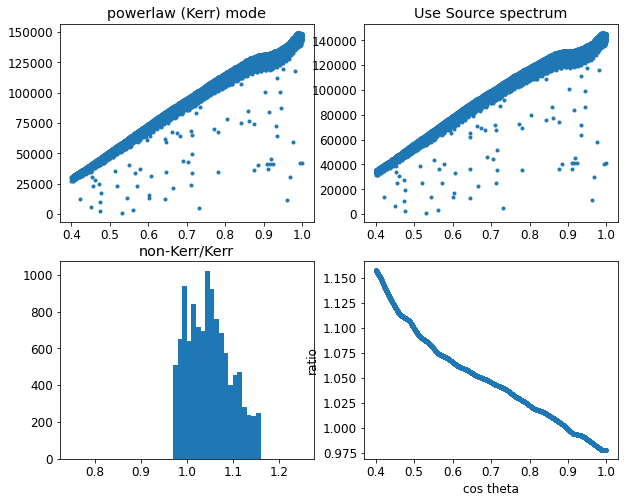

In [ ]:
    plt.rc('font', size=12)
    fig, axx = plt.subplots(2,2, figsize=(10,8))
    (ax1,ax2,ax3,ax4) = axx.flatten()
    ax1.plot(expk.cos_theta, expk.exp,'.');

    ax1.set(title='powerlaw (Kerr) mode')

    ax2.plot(expnk.cos_theta, expnk.exp,'.');
    ax2.set(title='Use Source spectrum')
    ratio = expnk.exp/expk.exp
    ax3.hist(ratio,  bins=np.linspace(0.75,1.25, 51))
    ax3.set(title='non-Kerr/Kerr');
    ax4.plot(expnk.cos_theta, ratio, '.');
    ax4.set(xlabel='cos theta', ylabel='ratio');

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()
!date

Converted 00_config.ipynb.
Converted 01_data_man.ipynb.
Converted 02_effective_area.ipynb.
Converted 03_exposure.ipynb.
Converted 03_sources.ipynb.
Converted 04_load_data.ipynb.
Converted 04_simulation.ipynb.
Converted 05_source_data.ipynb.
Converted 06_poisson.ipynb.
Converted 07_loglike.ipynb.
Converted 08_cell_data.ipynb.
Converted 09_lightcurve.ipynb.
Converted 14_bayesian.ipynb.
Converted 90_main.ipynb.
Converted 99_presentation.ipynb.
Converted 99_tutorial.ipynb.
Converted index.ipynb.
Sun Sep 19 09:37:48 PDT 2021
